In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from keras.preprocessing import image
from keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

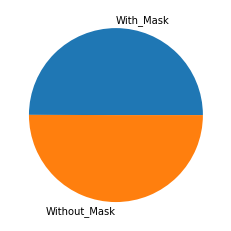

In [9]:
#visualization
images = ['With_Mask','Without_Mask'] 
data = [1915,1918] 
plt.pie(data, labels = images)
plt.show()

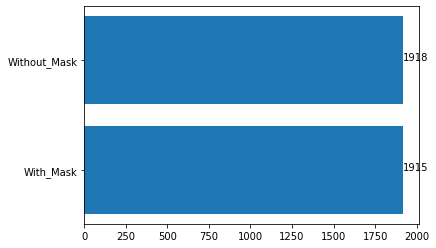

In [10]:
import matplotlib.pyplot as plt


x = ['With_Mask','Without_Mask']
y = [1915,1918] 
plt.barh(x, y)


for index, value in enumerate(y):
    plt.text(value, index, str(value))

In [11]:
#Data preprocessing

print("    Progress --- Loading Images")

DIRECTORY = r"M\dataset"
CATEGORIES = ["with_mask", "without_mask"]

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)  
    for img in os.listdir(path):
        img_path = os.path.join(path, img)  
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)
        

    Progress --- Loading Images


In [12]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

        
data = np.array(data, dtype="float32")
labels = np.array(labels)

(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [13]:
#model Creation
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

In [14]:
#configuring the model.
print("    Progress --- configuring model")

INIT_LR = 1e-4
EPOCHS = 3
BS = 32

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

#training the model
print("    Progress --- training model")
H = model.fit(
    aug.flow(X_train, Y_train, batch_size=BS),
    steps_per_epoch=len(X_train) // BS,
    validation_data=(X_test, Y_test),
    validation_steps=len(X_test) // BS,
    epochs=EPOCHS)

    Progress --- configuring model
    Progress --- training model
Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
95/95 [==============================] - ETA: 0s - loss: 0.4262 - accuracy: 0.8527WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000018036B19828> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, se

In [15]:
#testing the model
predIdxs = model.predict(X_test, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(Y_test.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [16]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# showing the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[380   3]
 [  2 382]]
acc: 0.9935
sensitivity: 0.9922
specificity: 0.9948


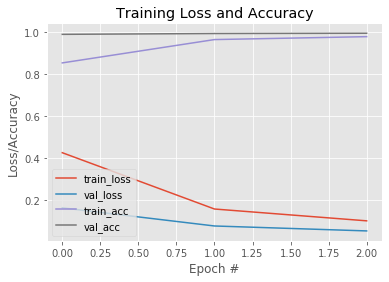

In [17]:
#perfomance visualization
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

Prediction: NO MASK


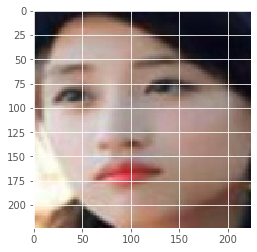

In [19]:
#prediction of images 
from keras.preprocessing import image
img = image.load_img('M/dataset/without_mask/0_0_huangtingting_0008.jpg', target_size=(224, 224))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
New_pred = np.argmax(classes, axis=1)
if New_pred==[1]:
  print('Prediction: NO MASK')
else:
  print('Prediction: MASK')

    Prediction: MASK


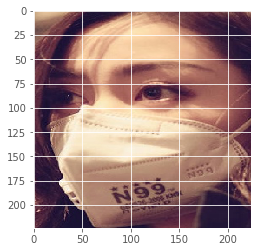

In [20]:
img = image.load_img('M/dataset/with_mask/0_0_0.jpg', target_size=(224, 224))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
New_pred = np.argmax(classes, axis=1)
if New_pred==[1]:
  print('    Prediction: NO MASK')
else: 
  print('    Prediction: MASK')

    Prediction: MASK


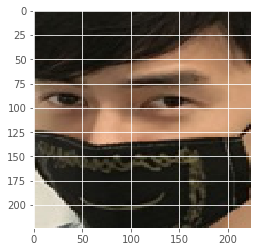

In [21]:
img = image.load_img('M/dataset/with_mask/0_0_0 copy 15.jpg', target_size=(224, 224))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
New_pred = np.argmax(classes, axis=1)
if New_pred==[1]:
  print('    Prediction: NO MASK')
else:
  print('    Prediction: MASK')

    Prediction: NO MASK


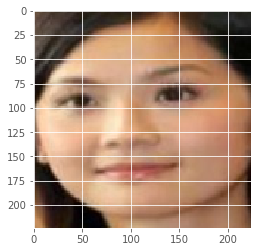

In [22]:
img = image.load_img('M/dataset/without_mask/0_0_caizhuoyan_0027.jpg', target_size=(224, 224))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
New_pred = np.argmax(classes, axis=1)
if New_pred==[1]:
  print('    Prediction: NO MASK')
else:
  print('    Prediction: MASK')

    Prediction: NO MASK


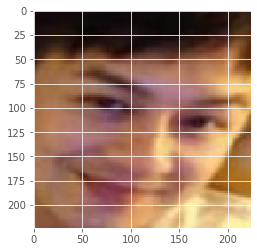

In [23]:
img = image.load_img('M/dataset/without_mask/0_0_chenhaomin_0117.jpg', target_size=(224, 224))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
New_pred = np.argmax(classes, axis=1)
if New_pred==[1]:
  print('    Prediction: NO MASK')
else:
  print('    Prediction: MASK')